In [1]:
from Utils import *
from import_data import * 

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

# load dataset
breast_cancer = load_breast_cancer()

type(breast_cancer)
# sklearn.utils.Bunch

# to see detailed description of dataset
print(breast_cancer.DESCR)
breast_cancer.data.shape
# (569, 30) : 569 datapoints i.e rows and 30 columns

breast_cancer.target.shape
# (569,) # 569 labels as 0 or 1
raw_data = breast_cancer.data

# normalized data
normalized_data = StandardScaler().fit_transform(raw_data)

# initialize pca with 2 components
pca = PCA(n_components=2)

# fit data
pca_data = pca.fit_transform(normalized_data)
# Variance explained by principal components
print(pca.explained_variance_ratio_)
# [0.44272026 0.18971182]

# Total Variance explained by principal components
total_var = 100 * np.sum(pca.explained_variance_ratio_)
print(f'{total_var:.3}% of total variance is explained by 2 principal components')
# 63.2% of total variance is explained by 2 principal components

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

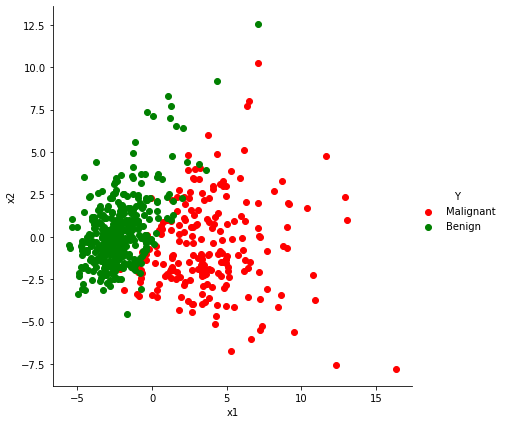

In [3]:
# Create dataframe 
pca_df = pd.DataFrame(np.vstack((pca_data.T, breast_cancer.target)).T,
                      columns = ['x1', 'x2', 'Y'])


# Replace 0 with Malignant and 1 with Benign
pca_df['Y'].replace(0.0, 'Malignant',inplace=True)
pca_df['Y'].replace(1.0, 'Benign',inplace=True)

# Check the count of label
pca_df.Y.value_counts()

# Benign       357
# Malignant    212
# This count matches with labels as per dataset description

# Create Plot
# Set palette of colors for different labels
pal = dict(Malignant="red", Benign="green")

ax = sns.FacetGrid(pca_df, hue='Y', height=6, palette=pal,
                   hue_order=["Malignant", "Benign"]).\
                   map(plt.scatter, 'x1', 'x2').\
                   add_legend()

plt.show()

In [7]:
pca_df.head()
df=pca_df
pca_df.Y.value_counts()

Benign       357
Malignant    212
Name: Y, dtype: int64

In [8]:
g = df.groupby('Y')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df.Y.value_counts()

Benign       212
Malignant    212
Name: Y, dtype: int64

In [9]:
df = df.sample(frac=.15)
df.Y.value_counts()

Benign       32
Malignant    32
Name: Y, dtype: int64

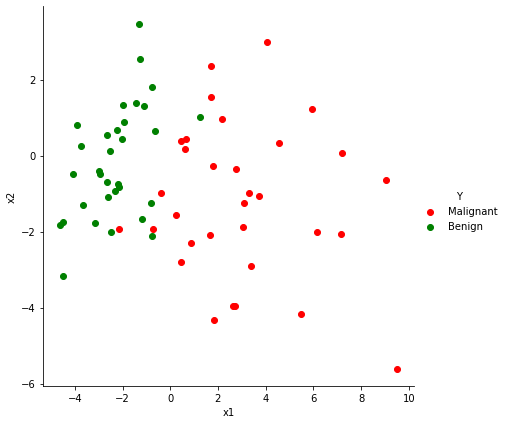

In [10]:
pal = dict(Malignant="red", Benign="green")

ax = sns.FacetGrid(df, hue='Y', height=6, palette=pal,
                   hue_order=["Malignant", "Benign"]).\
                   map(plt.scatter, 'x1', 'x2').\
                   add_legend()

plt.show()

In [11]:
X=df.iloc[:,0:2].to_numpy()
Y=df.iloc[:,2].to_numpy()
Y=np.where(Y=='Benign', 0, 1)

In [ ]:
# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X), 1))
# X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
# print("First X sample (padded)    :", X_pad[0])

# # normalize each input
# normalization = np.sqrt(np.sum(X_pad ** 2, -1))
# X_norm = (X_pad.T / normalization).T
# print("First X sample (normalized):", X_norm[0])

# # angles for state preparation are new features
# features = np.nan_to_num((np.array([get_angles(x) for x in X_norm])))
# print("First features sample      :", features[0])

In [12]:
# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[5])

First X sample (normalized): [0.99997053 0.00767715]


In [13]:
def get_Sx(ang=None, x=None, pad=False):
    backend = Aer.get_backend('unitary_simulator')

    if pad==True:
        q = QuantumRegister(2)
        circuit = QuantumCircuit(q)
        circuit = state_preparation(ang, circuit, [0, 1])
    elif pad==False:
        x = x.astype(complex)
        q = QuantumRegister(1)
        circuit = QuantumCircuit(q)
        circuit.initialize(x, [q])

    job = execute(circuit, backend)
    result = job.result()
    U = result.get_unitary(circuit)
    S = Operator(U)
    return S

In [14]:
def linear_operator(param, pad=False):
    backend = Aer.get_backend('unitary_simulator')
    '''pad variable influences the size of params vector'''
    if pad==True:
        data = QuantumRegister(2)
        qc = QuantumCircuit(data_reg)
        qc.u3(param[0], param[1], param[2], data[0])
        qc.u3(param[3], param[4], param[5], data[1])
        qc.cx(data[0], data[1])
    elif pad==False:
        data = QuantumRegister(1)
        qc = QuantumCircuit(data)
        qc.u3(param[0], param[1], param[2], data)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    G = Operator(U)
    return G


In [15]:

def sigma(pad=False):
    backend = Aer.get_backend('unitary_simulator')
    if pad==True:
        data = QuantumRegister(2)
        qc = QuantumCircuit(data)
        qc.id(data)
    if pad==False:
        data = QuantumRegister(1)
        qc = QuantumCircuit(data)
        qc.id(data)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    I = Operator(U)
    return I

In [16]:
def R_gate(beta):
    backend = Aer.get_backend('unitary_simulator')
    control = QuantumRegister(1)
    qc = QuantumCircuit(control)
    qc.ry(beta, control)

    job = execute(qc, backend)
    result = job.result()

    U = result.get_unitary(qc)
    R = Operator(U)
    return R

In [17]:
def create_circuit(parameters=None, x=None, pad=False):
    beta = parameters[0]
    theta1 = parameters[1:4]
    theta2 = parameters[4:7]

    control = QuantumRegister(1, 'control')
    data = QuantumRegister(1, 'x')
    temp = QuantumRegister(1, 'temp')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(control, data, temp, c)

    S=get_Sx(x=x)
    qc.unitary(S, data, label='$S_{x}$')

    R=R_gate(beta)
    qc.unitary(R, control, label='$R_{Y}(β)$')

    qc.barrier()
    qc.cswap(control, data, temp)

    G1 = linear_operator(theta1)
    qc.unitary(G1, data, label='$G(θ_{1})$')

    G2 = linear_operator(theta2)
    qc.unitary(G2, temp, label='$G(θ_{2})$')

    qc.cswap(control, data, temp)
    qc.barrier()

    sig = sigma()
    qc.unitary(sig, data, label='$Σ$')

    qc.barrier()
    qc.measure(data[0], c)
    return qc



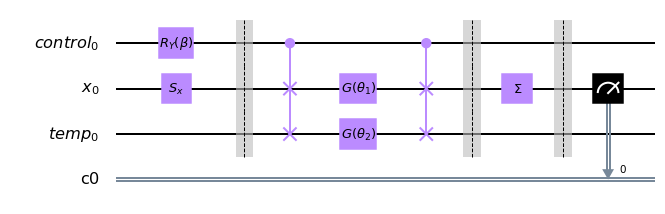

In [18]:
c=create_circuit(parameters=range(7), x=np.array([0,1]))
c.draw(output='mpl')

In [19]:
def execute_circuit(parameters, x=None, shots=1000, print=False):
    backend = BasicAer.get_backend('qasm_simulator')

    circuit=create_circuit(parameters, x)
    if print:
        circuit.draw(output='mpl')
        plt.show()
    result = execute(circuit, backend, shots=shots).result()

    counts = result.get_counts(circuit)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    return result[1]



def cost(params, X, labels):
    predictions = [execute_circuit(params, x) for x in X]
    return binary_crossentropy(labels, predictions)

In [20]:
X = X_norm.copy()
# seed = 974 # iris:359, gaussian:527
seed=np.random.randint(0,10**3,1)[0]
np.random.seed(seed)
current_params = (0.1*np.random.randn(7))

from qiskit.aqua.components.optimizers import AQGD
optimizer_step = AQGD(maxiter=1, eta=2.0, disp=False)
execute_circuit(current_params, x=X[2], print=True)


num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X[index[num_train:]]
Y_val = Y[index[num_train:]]
batch_size = 10
T = 10
acc_final_tr = 0
acc_final_val = 0

In [21]:
optimizer_step = AQGD(maxiter=10, eta=2.0, disp=True)

obj_function = lambda params: cost(params, X_train, Y_train)
point, value, nfev = optimizer_step.optimize(len(current_params), obj_function, initial_point=current_params)

Iteration: 0 	| Energy: 1.3232868781770597
Iteration: 1 	| Energy: 1.3622352325715112
Iteration: 2 	| Energy: 1.1152395761893408
Iteration: 3 	| Energy: 0.8621509874861745
Iteration: 4 	| Energy: 0.586334496757512
Iteration: 5 	| Energy: 0.20960591880959015
Iteration: 6 	| Energy: 0.28703415345500505
Iteration: 7 	| Energy: 0.31401558194820683
Iteration: 8 	| Energy: 0.23781216412770356
Iteration: 9 	| Energy: 0.20221285488008064
Iteration: 10 	| Energy: 0.20636739325134631


In [ ]:
for i in range(T):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    obj_function = lambda params: cost(params, X_batch, Y_batch)
    point, value, nfev = optimizer_step.optimize(len(current_params), obj_function,
                                                 initial_point=current_params)
    current_params = point
    print(
        "Iter: {:5d} | Cost: {:0.7f}"
        "".format(i + 1, cost(current_params, X_train, Y_train)))

    # Compute predictions on train and validation set
    # probs_train = [execute_circuit(point, x) for x in X_train]
    # probs_val = [execute_circuit(point, x) for x in X_val]

    # predictions_train = [predict(p) for p in probs_train]
    # predictions_val = [predict(p) for p in probs_val]

    # acc_train = accuracy(Y_train, predictions_train)
    # acc_val = accuracy(Y_val, predictions_val)

#     if acc_final_tr < acc_train:
#         best_param = point
#         acc_final_tr = acc_train
#         acc_final_val = acc_val
#         best_seed = seed
#         iteration = i

#     print(
#         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
#         "".format(i + 1, cost(point, X_train, Y_train), acc_train, acc_val))

In [ ]:
probs_train = [execute_circuit(point, x) for x in X_train]
probs_val = [execute_circuit(point, x) for x in X_val]

predictions_train = [predict(p) for p in probs_train]
predictions_val = [predict(p) for p in probs_val]

acc_train = accuracy(Y_train, predictions_train)
acc_val = accuracy(Y_val, predictions_val)

print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(point, X_train, Y_train), acc_train, acc_val))

In [ ]:
probs_train = [execute_circuit(point, x) for x in X_train]
probs_val = [execute_circuit(point, x) for x in X_val]

predictions_train = [predict(p) for p in probs_train]
predictions_val = [predict(p) for p in probs_val]

acc_train = accuracy(Y_train, predictions_train)
acc_val = accuracy(Y_val, predictions_val)

print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(current_params, X_train, Y_train), acc_train, acc_val))

In [ ]:
print("Final model: Cost: {:0.7f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
      "".format(cost(current_params, X_train, Y_train), acc_final_tr, acc_final_val))